# Functional prior

Minimal Jax implementation of [All You Need is a Good Functional Prior for Bayesian Deep Learning](https://arxiv.org/abs/2011.12829) by Tran, et.al.

In [1]:
import jax
import optax
import gpjax as gpx
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from typing import Callable
from jax.flatten_util import ravel_pytree

/Users/gerardoduran/miniforge3/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/gerardoduran/miniforge3/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [2]:
%config InlineBackend.figure_format = "retina"

In [27]:
key = jax.random.PRNGKey(314)
key_gp, key_bnn, key_1l = jax.random.split(key, 3)

## GP prior

In [28]:
meanf = gpx.mean_functions.Zero()
kernel = gpx.kernels.RBF()

prior = gpx.Prior(mean_function=meanf, kernel=kernel)

In [29]:
n_samples = 20
xtest = jnp.linspace(-3, 3, 100)[:, None]
dist_prior = prior(xtest)

samples = dist_prior.sample(key_bnn, (n_samples,))

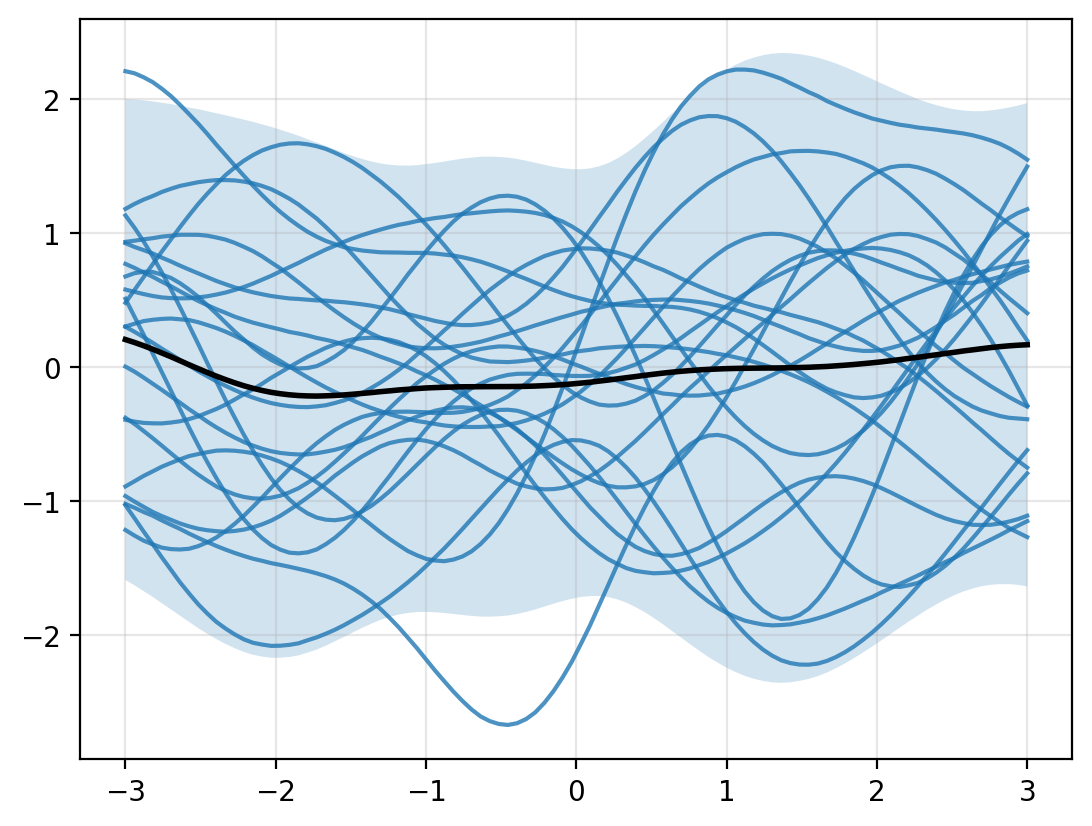

In [30]:
mean = samples.mean(axis=0)
std = samples.std(axis=0)

lbound = mean - 2 * std
ubound = mean + 2 * std

for sample in samples:
    plt.plot(xtest.ravel(), sample, c="tab:blue", alpha=0.8)
plt.grid(alpha=0.3)

plt.fill_between(xtest.ravel(), lbound, ubound, alpha=0.2)
plt.plot(xtest.ravel(), mean, c="black", linewidth=2)

## BNN MFVI prior

We start with $\theta_m \sim {\cal N}(0, 1)$ for all $m=1,\ldots, M$.

In [31]:
class BNN(nn.Module):
    n_out: int = 1
    activation: Callable = nn.elu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x

In [83]:
bnn = BNN()
params_init = bnn.init(key, xtest)

In [84]:
flatp, rfn = ravel_pytree(params_init)
n_params = len(flatp)

In [85]:
key_param, key_rho = jax.random.split(key_bnn)

In [92]:
params_sample = jax.random.normal(key_bnn, (n_samples, n_params)) / 3
params_sample = jax.vmap(rfn)(params_sample)
samples = jax.vmap(bnn.apply, (0, None))(params_sample, xtest).squeeze()

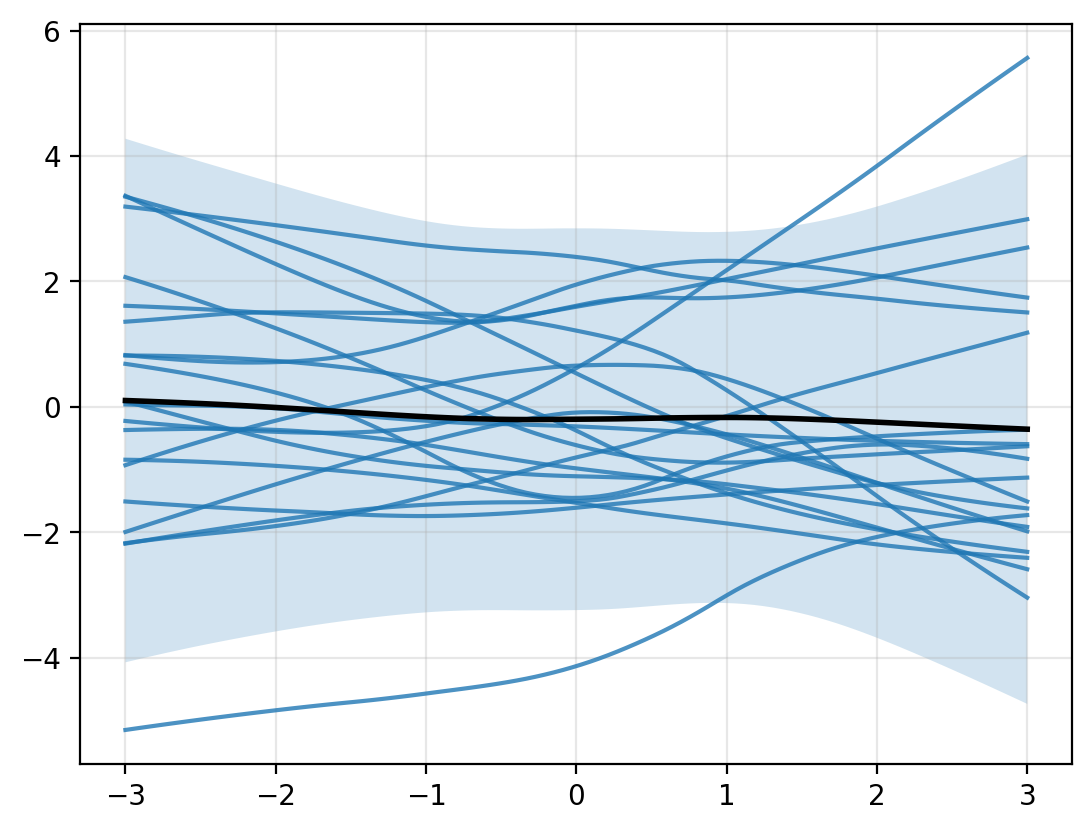

In [93]:
mean = samples.mean(axis=0)
std = samples.std(axis=0)

lbound = mean - 2 * std
ubound = mean + 2 * std

for sample in samples:
    plt.plot(xtest.ravel(), sample, c="tab:blue", alpha=0.8)
plt.grid(alpha=0.3)

plt.fill_between(xtest.ravel(), lbound, ubound, alpha=0.2)
plt.plot(xtest.ravel(), mean, c="black", linewidth=2)

# Wassertein Distance Optimisation

$$
    \min_\psi\max_\theta
    \mathbb{E}_{q}\left[
        \mathbb{E}_{p-\texttt{gp}}[\phi_{\boldsymbol\theta}(\text{f}_{\cal M})] -
        \mathbb{E}_{p-\texttt{nn}}[\phi_{\boldsymbol\theta}(\text{f}_{\cal M})]
    \right],
$$

where we define

$$
    {\cal L}(\psi, \theta) =
        \mathbb{E}_{p-\texttt{gp}}[\phi_{\boldsymbol\theta}(\text{f}_{\cal M})] -
        \mathbb{E}_{p-\texttt{nn}}[\phi_{\boldsymbol\theta}(\text{f}_{\cal M})]
$$,

* $\text{f}_\phi$ is a set of random variables from a **measurement set** ${\bf X}_{\cal M}$
* $\phi_\theta$ is a 1-Lipshitz function defined as an MLP with two hidden layers each, 200 units, and softplus activation function.

In [36]:
class Lip1(nn.Module):
    """
     1-Lipschitz function
    """
    n_out: int = 1
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(200)(x)
        x = nn.softplus(x)
        x = nn.Dense(200)(x)
        x = nn.softplus(x)
        x = nn.Dense(self.n_out)(x)
        return x

In [39]:
model_l1 = Lip1()
lparams = model_l1.init(key_1l, xtest)

## The measurement set

We want to obtain a GP-like prior in the range $[-3, 3]$.

In [41]:
n_lipschitz = 30

In [43]:
n_points = 100

In [46]:
# Sampled measurement set
Xm = jax.random.uniform(key, minval=-3, maxval=3, shape=(n_points,))